# Import Library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

# Config

In [2]:
# google colab free gpu 사용 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [3]:
EPOCHS = 50
BATCH_SIZE = 64

In [4]:
hidden_size = [512, 256, 128]
latent_size = 2
image_size = 28*28

# Load Data
- MNIST

In [5]:
# transform dataset 
transform = transforms.Compose([
            transforms.ToTensor(), 
            # transforms.Normalize((0.5,), (1.0,))
])

# Loading trainset, testset and trainloader, testloader
trainset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True,
                                        download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


testset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = False,
                                        download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/MNIST/MNIST/raw



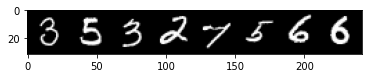

In [6]:
# visualization 

data, label = next(iter(trainloader))

img = torchvision.utils.make_grid(data[0:8])
plt.imshow(img.permute(1,2,0))
ax = plt.gca()
# plt.show()
plt.savefig('./tmp.png')

# VAE Layer

In [7]:
class VanillaVAE(nn.Module):
  def __init__(self, image_size, hidden_size, latent_size):
    super(VanillaVAE, self).__init__()

    self.latent_size = latent_size
    output_image_size = image_size

    #-- encoder
    modules = []
    for h in hidden_size:
      modules.append(
          nn.Sequential(
              nn.Linear(image_size, h),
              nn.ReLU()
          )
      )
      image_size = h

    self.encoder = nn.Sequential(*modules)
    self.fc_mu = nn.Linear(hidden_size[-1], latent_size)
    self.fc_var = nn.Linear(hidden_size[-1], latent_size)

    #-- decoder
    hidden_size.reverse()

    modules = []
    for h in hidden_size:
      modules.append(
          nn.Sequential(
              nn.Linear(latent_size, h),
              nn.ReLU()
          )
      )
      latent_size = h

      self.decoder = nn.Sequential(*modules)
      self.final_layer = nn.Sequential(
          nn.Linear(hidden_size[-1], output_image_size),
          nn.Sigmoid()
      )

  def encode(self, input):
    result = self.encoder(input)
    mu = self.fc_mu(result)
    logvar = self.fc_var(result)

    return mu, logvar 

  def decode(self, z):
    result = self.decoder(z)
    result = self.final_layer(result)

    return result

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)

    return eps * std + mu 

  def forward(self, input):
    mu, logvar = self.encode(input.view(-1, 28*28))
    z = self.reparameterize(mu, logvar)
    return [self.decode(z), input, mu, logvar] 

  def sample(self, num_samples):
    z = torch.randn(num_samples, self.latent_size).to(DEVICE)
    samples = self.decode(z)

    return samples

In [8]:
def loss_function(recon_x, x, mu, logvar):
  # x = x.view(-1, 784)
  # BCE = torch.sum(x*torch.log(recon_x) + (1-x)*torch.log(1-recon_x))
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE, KLD

# Train

In [9]:
VAE_model = VanillaVAE(image_size, hidden_size, latent_size).to(DEVICE)

optimizer = optim.Adam(VAE_model.parameters(), lr = 1e-3)

In [10]:
VAE_model

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [11]:
def train(epoch, model, train_loader, optimizer):
  model.train()

  train_loss = 0
  
  BCE_history, KLD_history = [], []

  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(DEVICE)
    optimizer.zero_grad()

    decoded, input, mu, logvar = model(data)

    BCE, KLD = loss_function(decoded, data, mu, logvar)

    loss = BCE + KLD

    loss.backward()

    train_loss += loss.item()
    BCE_history.append(BCE.item())
    KLD_history.append(KLD.item())

    optimizer.step()

    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader),
          loss.item() / len(data)))

  print("======> Epoch: {} Average loss: {:.4f}".format(
          epoch, train_loss / len(train_loader.dataset)
      ))        
  
  return BCE_history, KLD_history



In [12]:
def test(epoch, model, test_loader):
  model.eval()

  test_loss = 0

  with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
      data = data.to(DEVICE)

      decoded, input, mu, logvar = model(data)

      BCE, KLD = loss_function(decoded, input, mu, logvar)

      loss = BCE + KLD 

      if batch_idx % 20 == 0:
        n = min(data.size(0), 8)
        comparison = torch.cat([input[:n], decoded.view(BATCH_SIZE, 1, 28, 28)[:n]])
        grid = torchvision.utils.make_grid(comparison.cpu())

        plt.imshow(grid.permute(1,2,0))
        ax = plt.gca()
        # plt.show()
        plt.savefig(f'./test_batchidx_{batch_idx}_recon_img.png')        

In [13]:
def latent_to_image(epoch, model, sample_n):
  with torch.no_grad():
    sample = model.sample(sample_n)
    grid = torchvision.utils.make_grid(sample.view(sample_n, 1, 28, 28).cpu())
    plt.imshow(grid.permute(1,2,0))
    ax = plt.gca()
    # plt.show()
    plt.savefig(f'./test_epoch{epoch}_latent_recon_img.png')        

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 544.538391
Train Epoch: 0 [6400/60000 (11%)]	 Loss: 202.188858
Train Epoch: 0 [12800/60000 (21%)]	 Loss: 193.589203
Train Epoch: 0 [19200/60000 (32%)]	 Loss: 173.892746
Train Epoch: 0 [25600/60000 (43%)]	 Loss: 169.849564
Train Epoch: 0 [32000/60000 (53%)]	 Loss: 162.663376
Train Epoch: 0 [38400/60000 (64%)]	 Loss: 163.243820
Train Epoch: 0 [44800/60000 (75%)]	 Loss: 174.402023
Train Epoch: 0 [51200/60000 (85%)]	 Loss: 156.809631
Train Epoch: 0 [57600/60000 (96%)]	 Loss: 160.630524
======> Epoch: 0 Average loss: 177.5686


Train Epoch: 1 [0/60000 (0%)]	 Loss: 157.367783
Train Epoch: 1 [6400/60000 (11%)]	 Loss: 161.307724
Train Epoch: 1 [12800/60000 (21%)]	 Loss: 152.895355
Train Epoch: 1 [19200/60000 (32%)]	 Loss: 153.339417
Train Epoch: 1 [25600/60000 (43%)]	 Loss: 151.866776
Train Epoch: 1 [32000/60000 (53%)]	 Loss: 159.289734
Train Epoch: 1 [38400/60000 (64%)]	 Loss: 163.121201
Train Epoch: 1 [44800/60000 (75%)]	 Loss: 144.182877
Train Epoch: 1 [

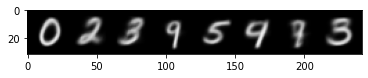

In [14]:
bce_total = []
kld_total = []

for epoch in tqdm(range(0, EPOCHS)):
    #-- train
    bce_history, kld_history = train(epoch, VAE_model, trainloader, optimizer)
    bce_total += bce_history
    kld_total += kld_history 

    #-- test 
    test(epoch, VAE_model, testloader)
    print("\n")

    #-- image generation from z
    latent_to_image(epoch, VAE_model, 8)

# Loss Visualization

In [16]:
import matplotlib.pyplot as plt

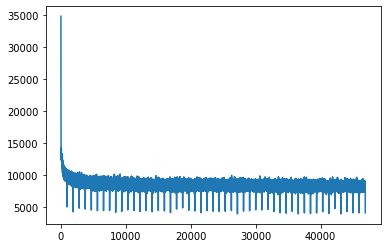

In [17]:
plt.plot(range(len(bce_total)), bce_total)
plt.show()

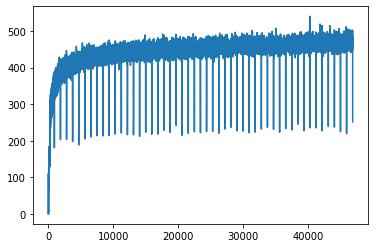

In [18]:
plt.plot(range(len(kld_total)), kld_total)
plt.show()

# generative image

> random latent to image

In [31]:
import cv2
from google.colab.patches import cv2_imshow

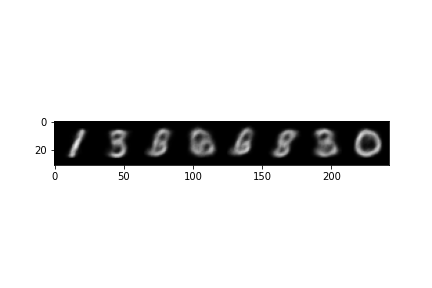

In [33]:
# iter1 
img = cv2.imread('./test_epoch0_latent_recon_img.png')
cv2_imshow(img)

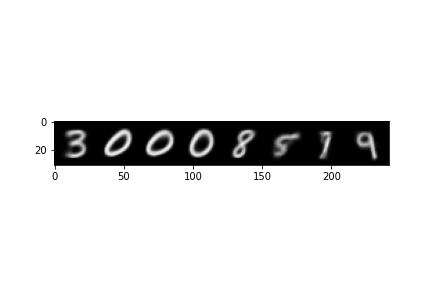

In [34]:
# iter20
img = cv2.imread('./test_epoch20_latent_recon_img.png')
cv2_imshow(img)

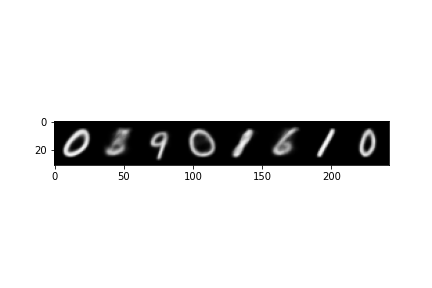

In [35]:
# iter35
img = cv2.imread('./test_epoch35_latent_recon_img.png')
cv2_imshow(img)

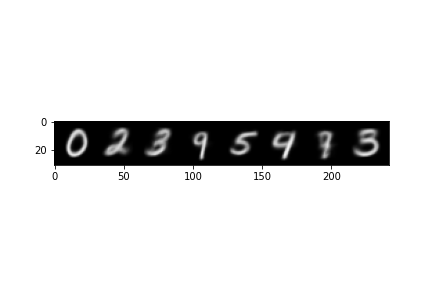

In [38]:
# iter50
img = cv2.imread('./test_epoch49_latent_recon_img.png')
cv2_imshow(img)

# generative image 

> input X와 decoded X 비교 

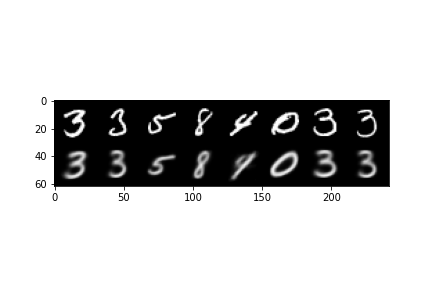

In [39]:
# iter50
img = cv2.imread('./test_batchidx_0_recon_img.png')
cv2_imshow(img)

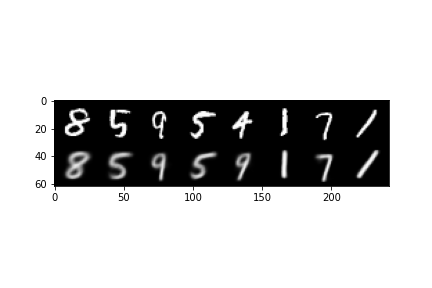

In [43]:
# iter50
img = cv2.imread('./test_batchidx_40_recon_img.png')
cv2_imshow(img)

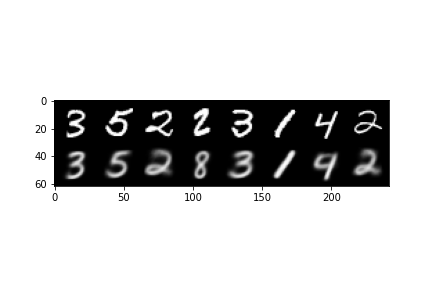

In [44]:
# iter50
img = cv2.imread('./test_batchidx_80_recon_img.png')
cv2_imshow(img)

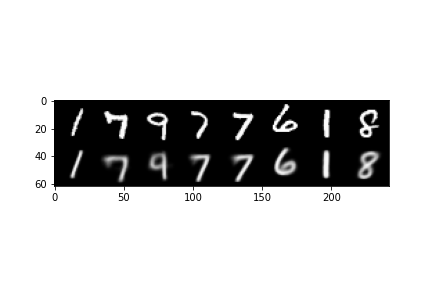

In [45]:
# iter50
img = cv2.imread('./test_batchidx_140_recon_img.png')
cv2_imshow(img)